In [4]:
"""Much of this code from the excellent https://github.com/higgsfield/RL-Adventure"""
import math, random
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import seaborn as sns

import sys
if "../../" not in sys.path:
  sys.path.append("../../") 

import collections
import torch.nn as nn

from  collections  import deque
%matplotlib inline

from IPython.display import clear_output

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [5]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [6]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. 
                                                                * frame_idx / epsilon_decay)

In [7]:
class Market(gym.Env):
    def __init__(self, kappa, episodes, time_periods, mu, r, sigma, inv_range):

        self.episodes = episodes
        self.time_periods = time_periods
        self.epi = 0
        self.t = 0

        self.inv_range = inv_range

        self.mu = mu
        self.r = r
        self.sigma = sigma

        self._start_wealth = 100.0
        self.kappa = kappa

        self.action_space = spaces.Discrete(len(inv_range))
        self.observation_space = spaces.Box(0,120, np.array([2]))
        
        self.seed(seed=0)
        self.viewer = None
        self.state = None

        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        self.S, self.B, self.dS, self.dB = self.generate_price_series()
        self.wealth = self._start_wealth
        #self.state = (int(self.S[self.t,self.epi]*100),int(self._start_wealth/10))
        
        self.state = (self.S[self.t,self.epi],self._start_wealth)
        return np.array(self.state)

    
    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        price_state, wealth_state = self.state
        
        prop = self.inv_range[action]
        prop = action
        
        discount = 0.99

        if self.t < self.time_periods:
            NB = (1-prop)*self.wealth/self.B[self.t]
            NS = prop*self.wealth/self.S[self.t, self.epi]
            # print(f"{prop=}")
            # print(f"{self.S[self.t]= }")
            # print(f"{self.B[self.t]= }")
            # print(f"{NS= }")
            # print(f"{NB= }")

            if self.t > 0:
                stonk_g = self.S[self.t, self.epi] / self.S[self.t-1, self.epi]
                # print(f"{stonk_g=}")
                bond_g = self.B[self.t] / self.B[self.t-1]
                # print(f"{bond_g=}")

            dX = NB*self.dB[self.t] + NS*self.dS[self.t,self.epi]
            # print(f"{dX=}")
            # print(f"{dX= }")
            reward = dX - (self.kappa/2)*(dX**2)  
            self.wealth += dX
            # print(f"{self.wealth= }")            

            done = False

            #self.wealth_state = int(self.wealth/10)
            self.wealth_state = self.wealth
            self.t += 1
            
            #new_state = (int(self.S[self.t,self.epi]*100), self.wealth_state)
            
            new_state = (self.S[self.t,self.epi], self.wealth_state)
            self.state = new_state
            final_wealth = 0.0
            
        else:
            #reached the end of episode...
            self.t = 0
            self.epi = 0 #+=1

            reward = 0.0
            dX = 0.0
            final_wealth = self.wealth
            done = True

            # print("------lol---------")

            _ = self.reset()

        return np.array(self.state), reward, done, final_wealth

    def generate_price_series(self):
        rng = np.random.RandomState(0)
        I = 1 #self.episodes
        M = self.time_periods

        S0 = 1
        B0 = 1
        T = 1.0
        dt = T/M

        mu = self.mu
        r = self.r
        sigma = self.sigma
        # print(f"{I}")
        # print(f"{M}")
        # print(f"{T}")
        # print(f"{dt}")
        # print(f"{mu}")
        # print(f"{r}")
        # print(f"{sigma}")

        S = np.zeros((M+1,I))
        dS = np.zeros((M,I))
        dB = np.zeros(M)

        B = np.zeros(M+1)
        B[0] = B0
        S[0] = S0

        for t in range(1, M+1):
            z = rng.standard_normal(I)
            # print(z)
            #df = 10
            #z = np.random.standard_t(df,I)
            S[t] = S[t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*math.sqrt(dt)*z)
            B[t] = B[t-1]*np.exp(r*dt)

        for t in range(1,M):
            dS[t] = S[t+1] - S[t]
            dB[t] = B[t+1] - B[t]

        # print(f"{S=},\n {B=}")
        return S, B, dS, dB

In [8]:
kappa = 0.008
episodes = 3000000
time_periods = 20
mu =0.10
rf = 0.02
sigma = 0.20

In [9]:
episodes = episodes #500k worked well? as did 1m

utes = 15
u_star = np.linspace(0,5, utes)

Mark = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star) #parameters from earlier

In [10]:
env = Mark

for _ in range(1):
    for i in range(time_periods):
        actions = 2
        if i == 0:
            states = env.reset()
        else:
            states, rewards, dones, info = env.step(actions)
            # print(f"{rewards=}")

        # print(states[1])
        # actions = np.random.uniform(low=0, high=1, size=(1,))
        

In [11]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
            #print(action)
            #print('nromal')
        else:
            action = random.randrange(env.action_space.n)
            #print('rand')
        return action

In [12]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

In [13]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [14]:
update_target(current_model, target_model)

In [15]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [16]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [17]:
num_frames = 500000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    
    action = current_model.act(state, epsilon) #norm
    #print(action)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        #print('here')
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 400 == 0:
        plot(frame_idx, all_rewards
                         ,np.convolve(losses,np.ones((1000,))/1000,mode='valid'))

    if frame_idx % 100 == 0:
        update_target(current_model, target_model)


<ipython-input-4-bbf9cf48f7e0>:29: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [30]:
episodes = 100001
wealth = 100.0
utilities_mod = []
rewards_mod = []
step_rewards = []
rsum = 0
wealth_episodes = []
number_of_actions = utes

Mark1 = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star)


for i_episode in range(episodes-1):

    if i_episode%10000 ==0:
        print(i_episode)
        
    state = Mark1.reset() 
    action = current_model(Variable(torch.FloatTensor(np.float32(state)))).argmax().item()

    while True:    
        new_state , reward, done, final_wealth = Mark.step(action) #(prop, wealth))
        action = current_model(Variable(torch.FloatTensor(np.float32(new_state)))).argmax().item()
        rsum += reward
        state = new_state

        #print(new_state)
        #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
        step_rewards.append(reward)

        if done:
            wealth_episodes.append(final_wealth)
            utilities_mod.append(np.log(final_wealth))
            rewards_mod.append(rsum)
            rsum = 0
            #wealth = 100.0
            #print(i_episode, final_wealth)
            break 


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [31]:
utilities_test = utilities_mod
rewards_test = rewards_mod
step_rew_test = step_rewards
wealth_test = wealth_episodes

In [1]:
import sys
sys.path.insert(0,r'C:\Users\akkon\Documents\programming\ai_wiwi\other_model')
sys.path.insert(0,r'C:\Users\akkon\Documents\programming\ai_wiwi\other_model\ddqn_relative\lib')
sys.path.insert(0,r'C:\Users\akkon\Documents\programming\ai_wiwi\other_model\ddqn_relative\lib\envs')

from lib.execute_strat import execute_strat
from lib.sim_prices import make_prices
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step

In [2]:
#episodes = 99##3000000
#Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa, episodes)

def make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                      utilities_test_best, utilities_test_rand, utilities_test,
                     wealth_test_rand, wealth_test_best, wealth_test):

    block_utilities_test = np.mean(np.array(utilities_test).reshape(1000,-1),0)
    block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
    block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)


    block_wealth_test_rand = np.mean(np.array(wealth_test_rand).reshape(1000,-1),0)
    block_wealth_test_best = np.mean(np.array(wealth_test_best).reshape(1000,-1),0)
    block_wealth_test = np.mean(np.array(wealth_test).reshape(1000,-1),0)


    block_rewards_test = np.mean(np.array(rewards_test).reshape(1000,-1),0)
    block_rewards_test_rand = np.mean(np.array(rewards_test_rand).reshape(1000,-1),0)
    block_rewards_test_best = np.mean(np.array(rewards_test_best).reshape(1000,-1),0)

    #Calculate sharpe ratios instead of longitudinally do it at the end blocks of 1000 again

    #mu - rf/ sigma
    wr = np.array(wealth_test_rand).reshape(100,-1)
    wr_sharpe = (wr.mean(axis=0)/100-1)/(wr.std(axis=0)/100)

    wt = np.array(wealth_test).reshape(100,-1)
    wt_sharpe = (wt.mean(axis=0)/100-1)/(wt.std(axis=0)/100)

    wb = np.array(wealth_test_best).reshape(100,-1)
    wb_sharpe = (wb.mean(axis=0)/100-1)/(wb.std(axis=0)/100)


    sns.distplot(block_rewards_test_best, label="Merton optimal")
    sns.distplot(block_rewards_test, label="Trained Agent")
    sns.distplot(block_rewards_test_rand, label="Random agent")
    plt.title('Distribution of Final rewards Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Rewards')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_rewards_test_rand, block_rewards_test, block_rewards_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Rewards", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Rewards - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_utilities_test_best, label="Merton optimal")
    sns.distplot(block_utilities_test, label="Trained Agent")
    sns.distplot(block_utilities_test_rand, label="Random agent")
    plt.title('Distribution of Final Utilities Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Utilities')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_utilities_test_rand, block_utilities_test, block_utilities_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of utilities - Random v Merton v Agent")
    plt.show()

    plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    plt.title('Moving average 10,000 episode utilities')
    plt.ylabel('Utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.violinplot([block_wealth_test_rand, block_wealth_test, block_wealth_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Wealth", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Wealth - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_wealth_test_best, label="Merton optimal")
    sns.distplot(block_wealth_test, label="Trained Agent")
    sns.distplot(block_wealth_test_rand, label="Random agent")
    plt.title('Distribution of Final Wealth Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Wealth')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sharpe, wt_sharpe, wb_sharpe])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Sharpe", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Sharpe ratios (M period) - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sharpe, label="Merton optimal")
    sns.distplot(wt_sharpe, label="Trained Agent")
    sns.distplot(wr_sharpe, label="Random agent")
    plt.title('Distribution of Final Sharpe ratios  Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Sharpe')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return block_utilities_test_rand, block_utilities_test, block_utilities_test_best, \
           block_rewards_test_rand, block_rewards_test, block_rewards_test_best, \
           block_wealth_test_rand, block_wealth_test, block_wealth_test_best, \
           wr_sharpe, wt_sharpe, wb_sharpe

In [3]:
wealth = 100.0

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
#temp change to execute strat
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random',
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)

NameError: name 'mu' is not defined

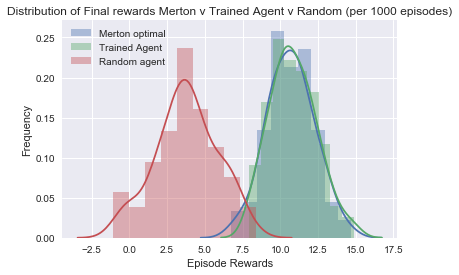

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


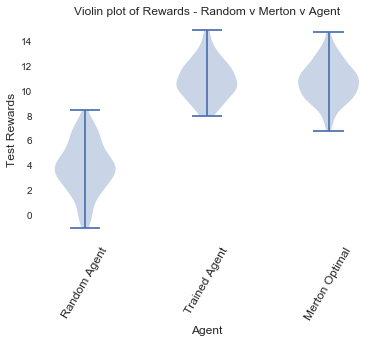

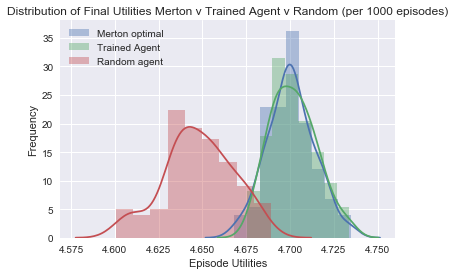

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


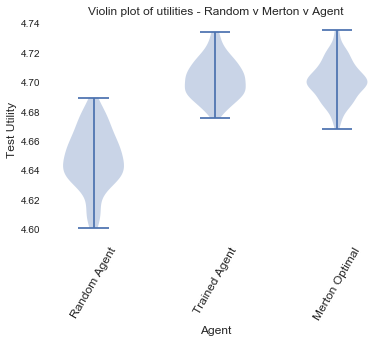

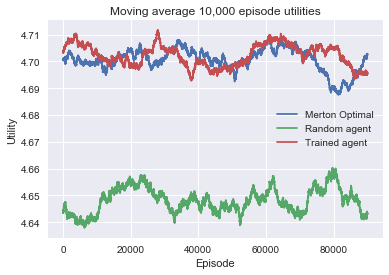

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


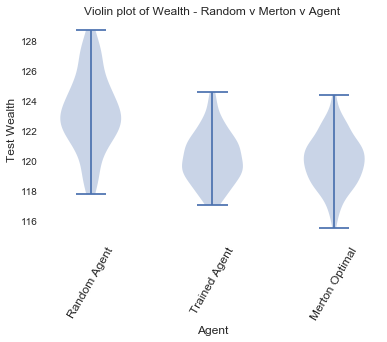

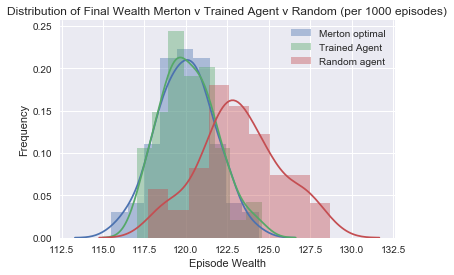

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


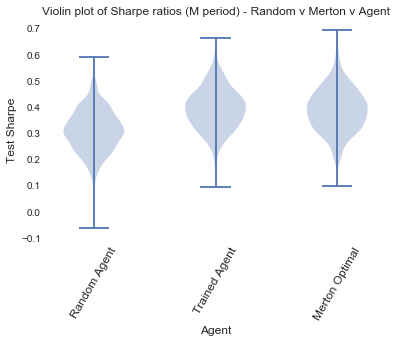

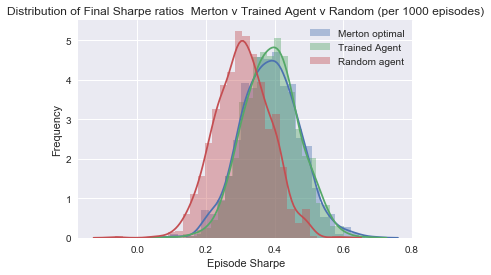

In [ ]:
#utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
#                                                            'Agent', q_values=Q, 
#                                                            time_periods=time_periods, wealth=wealth)

results = make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                  utilities_test_best, utilities_test_rand, utilities_test,
                         wealth_test_rand, wealth_test_best, wealth_test)

In [ ]:
for r in results:
    print(np.mean(r))

4.647705717839808
4.701881007676416
4.700574399289017
3.785101694147847
10.857694452225248
10.680781864955206
123.22127414001936
120.16502411878824
119.97156581621101
0.3071353927660123
0.39031087515516705
0.38656642141334224


In [ ]:
for r in results:
    print(np.std(r))

0.01960570304115883
0.013054563404349621
0.013365193028326545
2.044535685985809
1.522981989512418
1.5608712810229721
2.4921318368608323
1.6696088372423477
1.7272311660207156
0.07901668508882188
0.0795374141722387
0.08426202053242544
